In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
import seaborn as sns
import json
import urllib.parse

In [2]:
with open('credentials.json') as f: 
    login = json.load(f)

username = login['user']
password = urllib.parse.quote(login['password']) 
host = login['host']
port = login['port']
db_name = login['name']

In [3]:
conn = create_engine(
    f"postgresql://{username}:{password}@{host}:{port}/{db_name}"
)

In [4]:
with open("../sql/04_cohort_retention_rate.sql", "r") as f:
    cohort_query = f.read()

df = pd.read_sql_query(text(cohort_query), con=conn)

df.head()

,cohort_month,cohort_index,num_customers,cohort_size,retention_rate
0,2018-08-01 00:00:00-07:00,1.0,7086,7086,1.000
1,2018-08-01 00:00:00-07:00,2.0,2742,7086,0.387
2,2018-08-01 00:00:00-07:00,3.0,3688,7086,0.520
3,2018-08-01 00:00:00-07:00,4.0,4654,7086,0.657
4,2018-08-01 00:00:00-07:00,5.0,2277,7086,0.321


In [5]:
df["cohort_month"] = pd.to_datetime(df["cohort_month"], utc=True).dt.to_period("M")

cohort_pivot = df.pivot_table(
    index="cohort_month",
    columns="cohort_index",
    values="retention_rate"
)

/var/folders/q2/9_rvc75s2yzgcz5xzfh1tm9w0000gn/T/ipykernel_69699/3329753848.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["cohort_month"] = pd.to_datetime(df["cohort_month"], utc=True).dt.to_period("M")


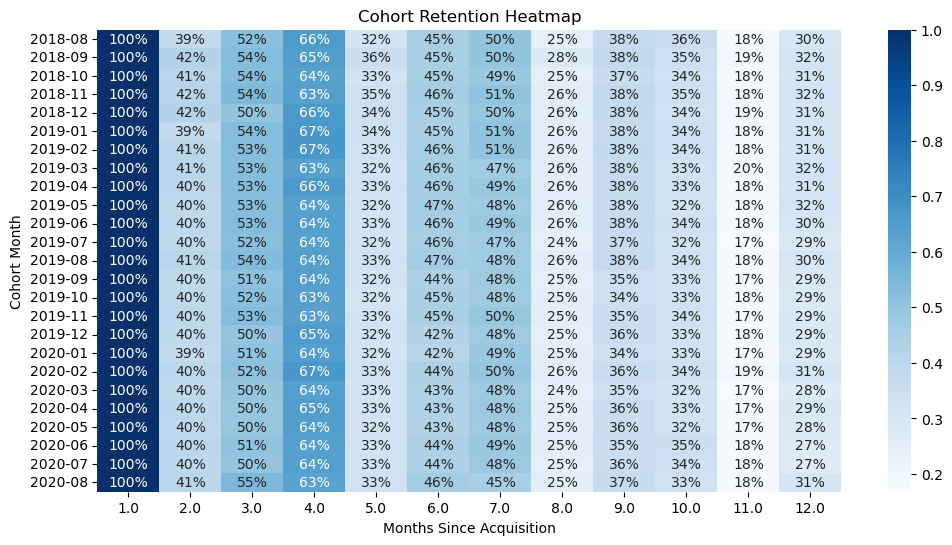

<Figure size 640x480 with 0 Axes>

In [6]:
plt.figure(figsize=(12,6))
sns.heatmap(
    cohort_pivot, 
    annot=True, fmt=".0%", cmap="Blues", cbar=True
)
plt.title("Cohort Retention Heatmap")
plt.ylabel("Cohort Month")
plt.xlabel("Months Since Acquisition")
plt.show()

plt.savefig("../img/cohort_heatmap.png")

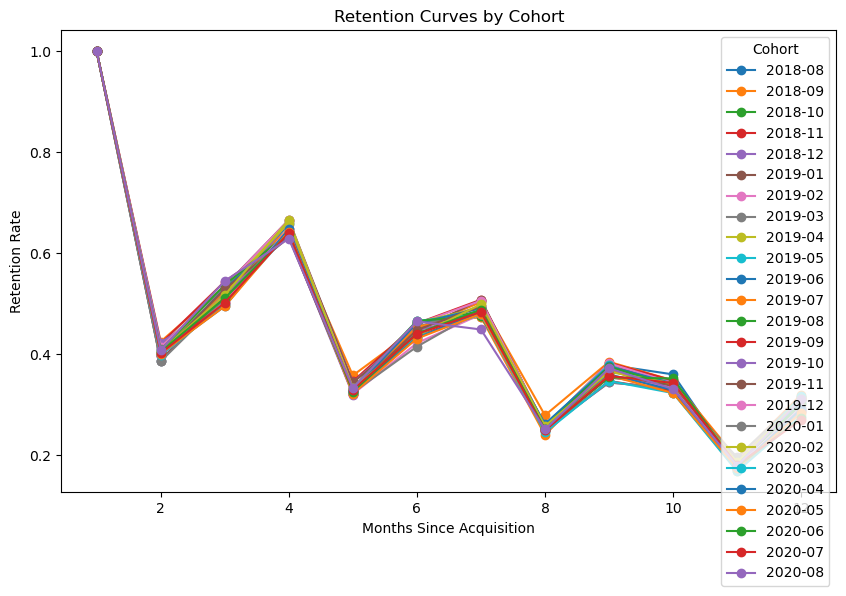

<Figure size 640x480 with 0 Axes>

In [7]:
plt.figure(figsize=(10,6))
for cohort in cohort_pivot.index:
    plt.plot(
        cohort_pivot.columns, 
        cohort_pivot.loc[cohort], 
        marker='o', label=str(cohort)
    )
plt.title("Retention Curves by Cohort")
plt.xlabel("Months Since Acquisition")
plt.ylabel("Retention Rate")
plt.legend(title="Cohort")
plt.show()

plt.savefig("../img/cohort_ret_curve.png")


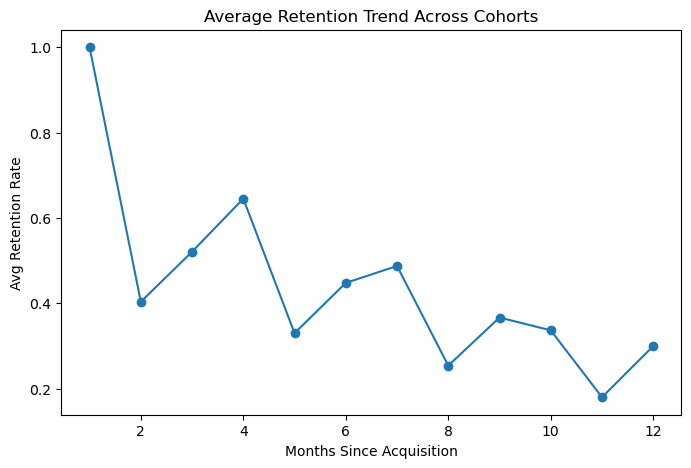

<Figure size 640x480 with 0 Axes>

In [8]:
avg_retention = cohort_pivot.mean()
plt.figure(figsize=(8,5))
plt.plot(avg_retention.index, avg_retention.values, marker='o')
plt.title("Average Retention Trend Across Cohorts")
plt.xlabel("Months Since Acquisition")
plt.ylabel("Avg Retention Rate")
plt.show()

plt.savefig("../img/avg_ret_curve.png")

In [9]:
with open("../sql/05_cohort_subscription_retention.sql", "r") as f:
    query = f.read()
    

df2 = pd.read_sql_query(text(query), con=conn)

df2.head()

,subscription_type,cohort_month,cohort_index,num_customers,cohort_size,retention_rate
0,B,2018-08-01 00:00:00-07:00,1.0,2414,2414,1.000
1,B,2018-08-01 00:00:00-07:00,2.0,936,2414,0.388
2,B,2018-08-01 00:00:00-07:00,3.0,891,2414,0.369
3,B,2018-08-01 00:00:00-07:00,4.0,1570,2414,0.650
4,B,2018-08-01 00:00:00-07:00,5.0,782,2414,0.324


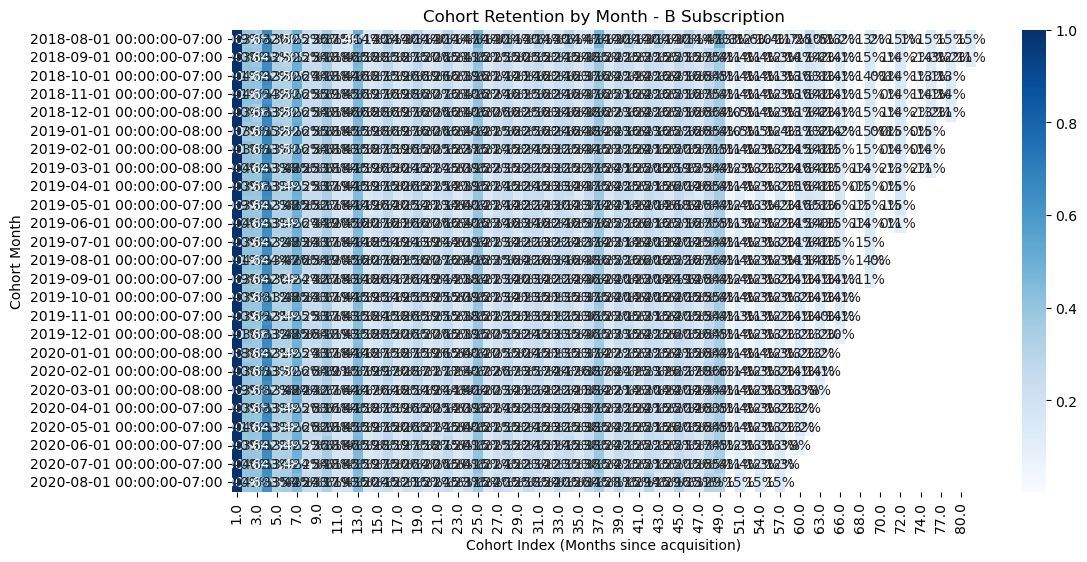

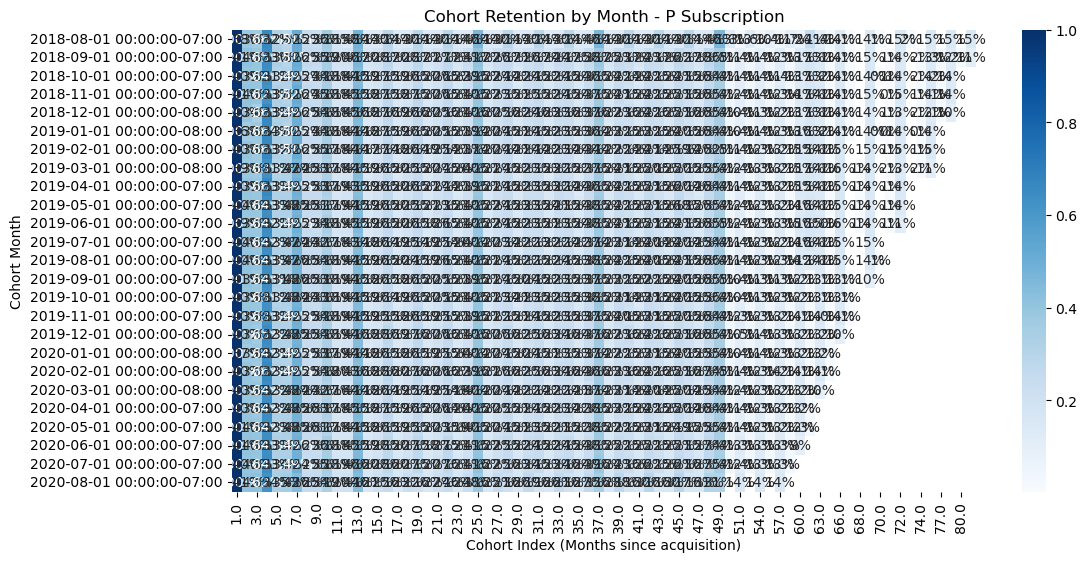

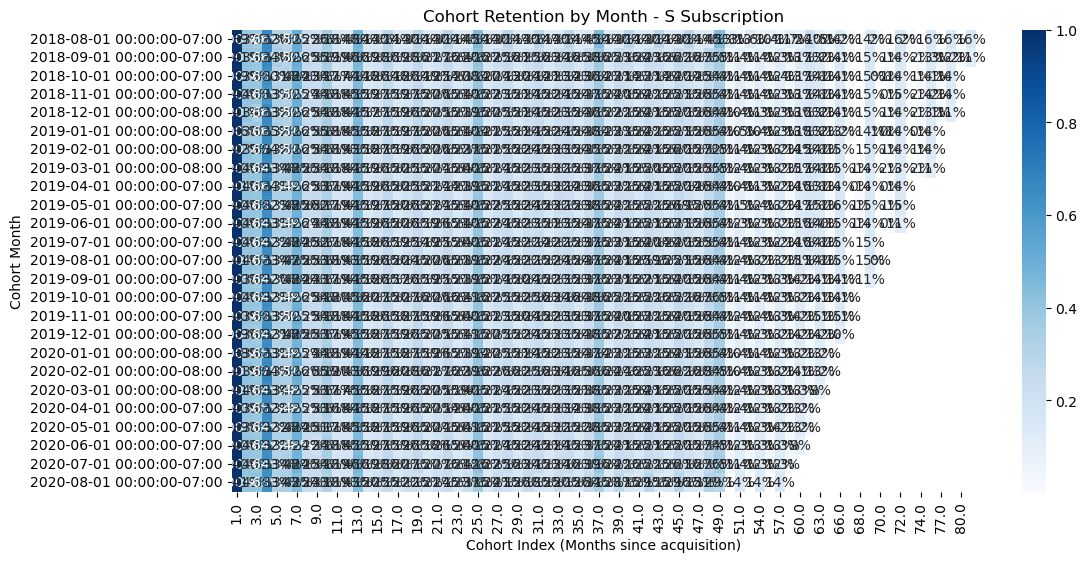

In [10]:
for sub_type in df2['subscription_type'].unique():
    subset = df2[df2['subscription_type'] == sub_type]
    
    cohort_pivot = subset.pivot_table(
        index="cohort_month", 
        columns="cohort_index", 
        values="retention_rate"
    )
    
    plt.figure(figsize=(12,6))
    sns.heatmap(cohort_pivot, annot=True, fmt=".0%", cmap="Blues")
    plt.title(f"Cohort Retention by Month - {sub_type} Subscription")
    plt.ylabel("Cohort Month")
    plt.xlabel("Cohort Index (Months since acquisition)")
    plt.show()

<Figure size 1200x600 with 0 Axes>

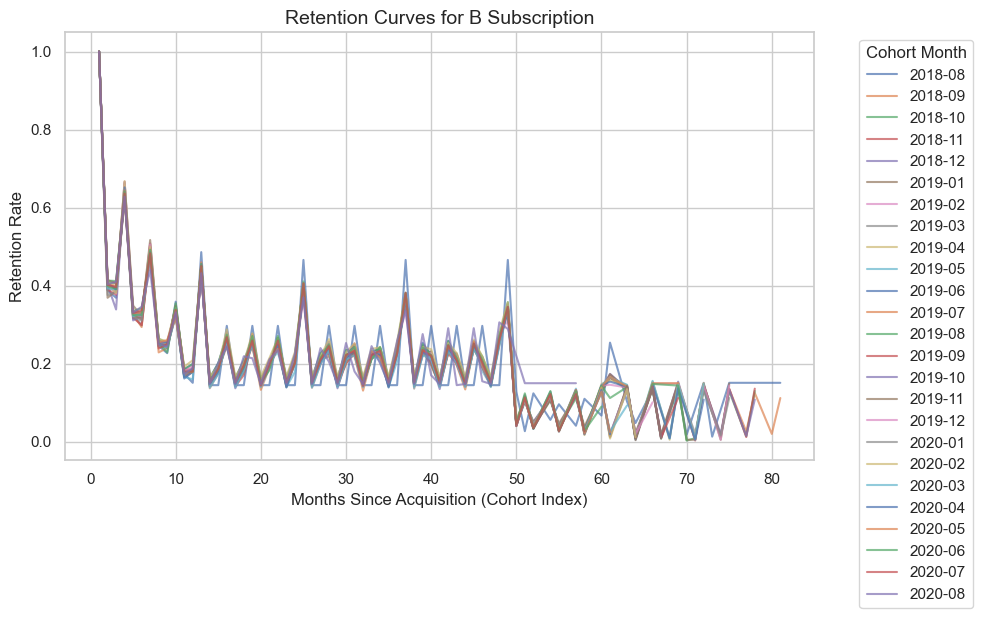

<Figure size 640x480 with 0 Axes>

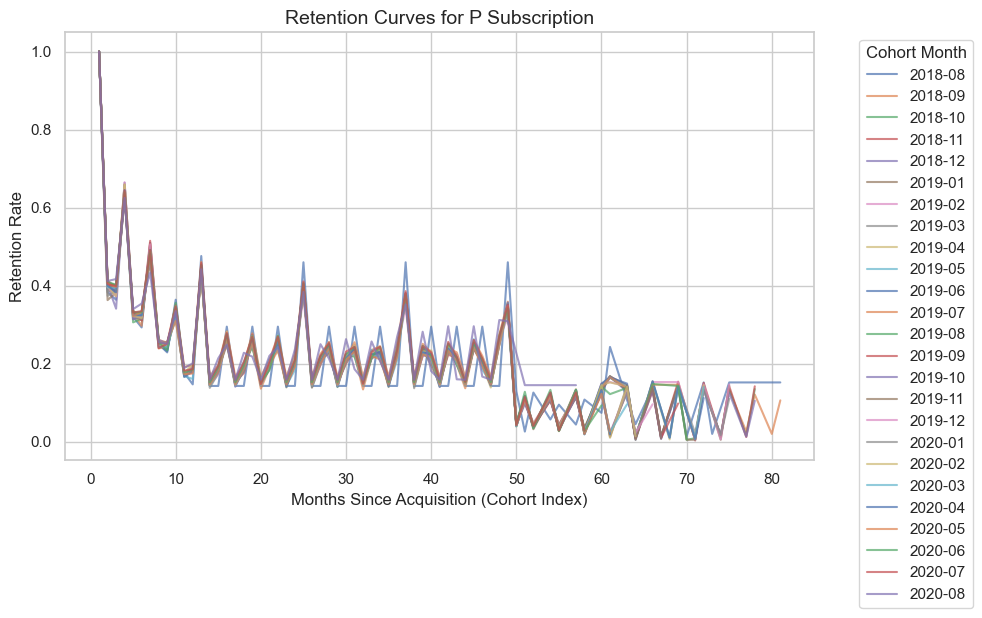

<Figure size 640x480 with 0 Axes>

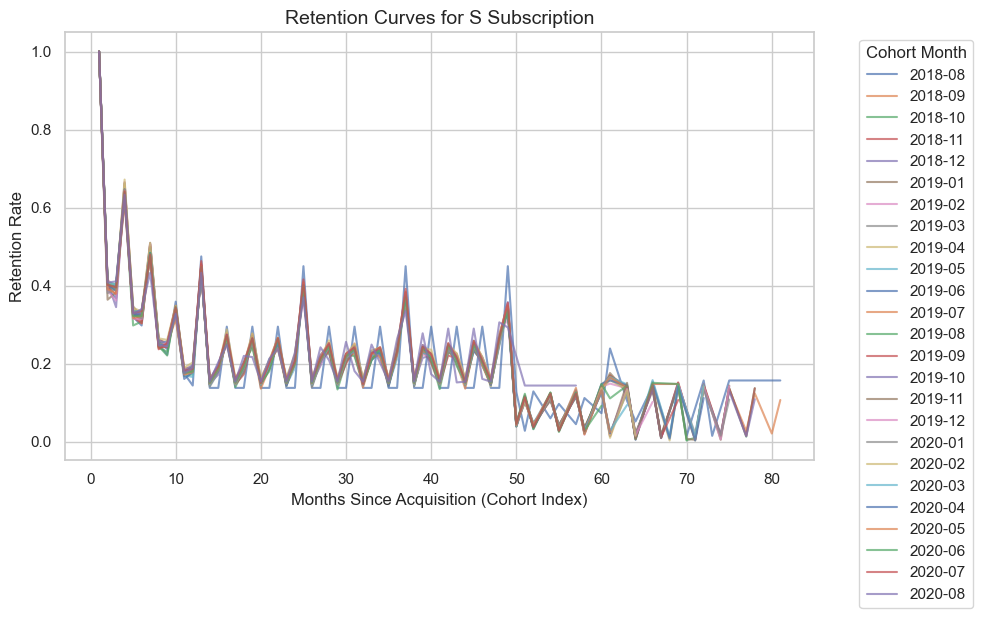

<Figure size 640x480 with 0 Axes>

In [11]:
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

subscription_types = df2['subscription_type'].unique()

for sub_type in subscription_types:
    plt.figure(figsize=(10, 6))
    
    subset = df2[df2['subscription_type'] == sub_type]
    
    # Plot each cohort as a line
    for cohort in subset['cohort_month'].unique():
        cohort_data = subset[subset['cohort_month'] == cohort]
        plt.plot(
            cohort_data['cohort_index'],
            cohort_data['retention_rate'],
            label=cohort.strftime("%Y-%m"),
            alpha=0.7
        )
    
    plt.title(f"Retention Curves for {sub_type} Subscription", fontsize=14)
    plt.xlabel("Months Since Acquisition (Cohort Index)")
    plt.ylabel("Retention Rate")
    plt.legend(title="Cohort Month", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
    
    plt.savefig("../img/subscription_curve.png")

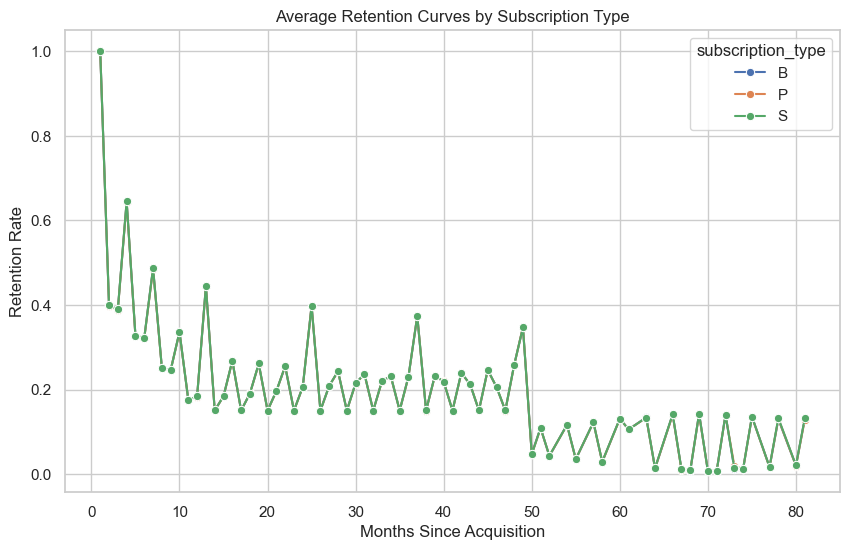

In [12]:
avg_curves = (
    df2.groupby(["subscription_type", "cohort_index"])["retention_rate"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,6))
sns.lineplot(
    data=avg_curves,
    x="cohort_index",
    y="retention_rate",
    hue="subscription_type",
    marker="o"
)

plt.title("Average Retention Curves by Subscription Type")
plt.xlabel("Months Since Acquisition")
plt.ylabel("Retention Rate")
plt.show()

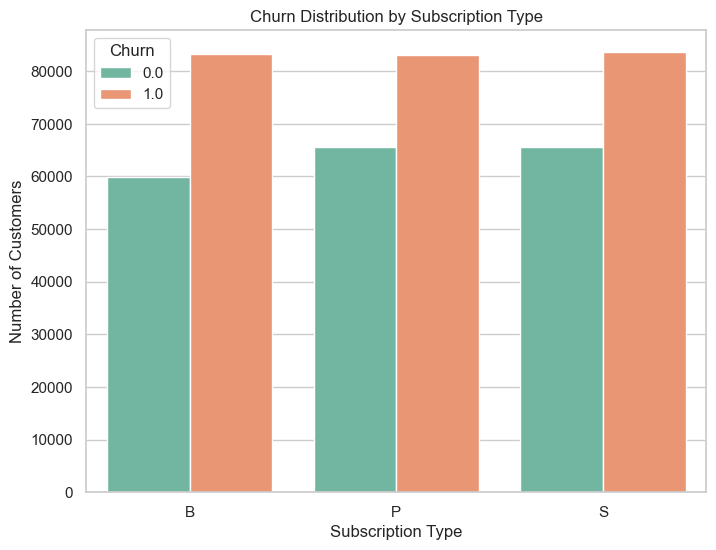

<Figure size 640x480 with 0 Axes>

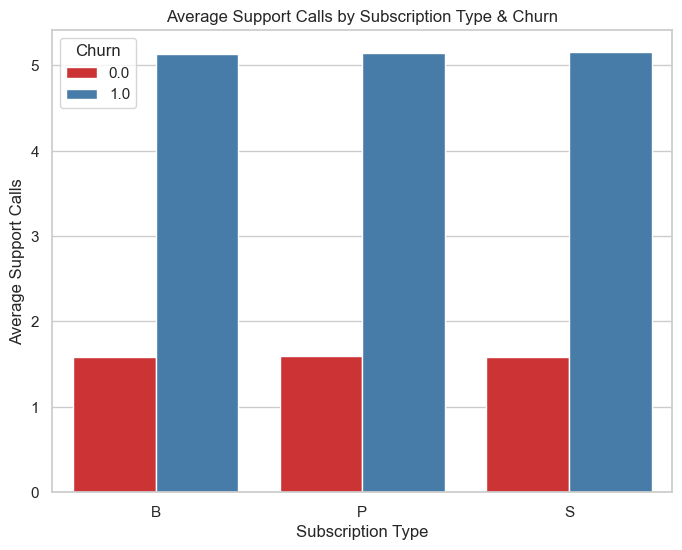

<Figure size 640x480 with 0 Axes>

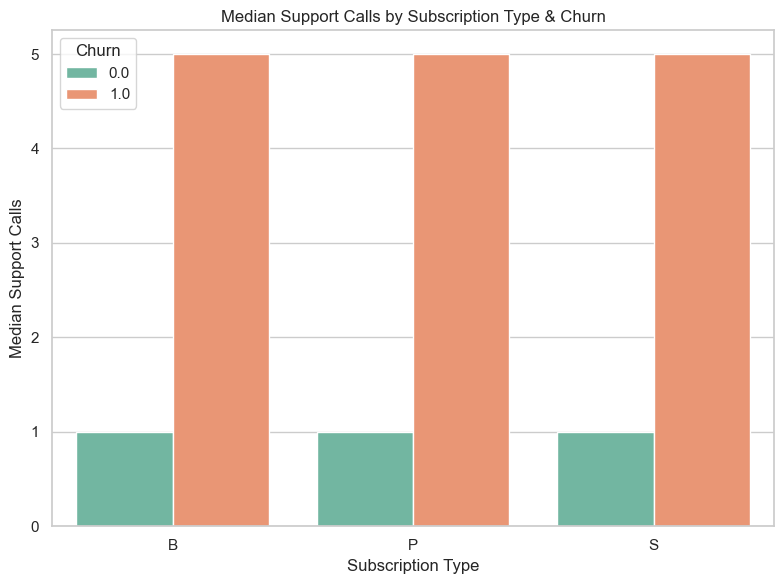

In [13]:
with open("../sql/06_churn_dist.sql", "r") as f:
    query = f.read()

df3 = pd.read_sql(query, conn)

# Plot churn distribution by subscription type
plt.figure(figsize=(8,6))
sns.barplot(data=df3, x="subscription_type", y="total_customers", hue="churn", palette="Set2")
plt.title("Churn Distribution by Subscription Type")
plt.xlabel("Subscription Type")
plt.ylabel("Number of Customers")
plt.legend(title="Churn")
plt.show()
plt.savefig("../img/churn_subscription.png")

# Plot average support calls by churn status
plt.figure(figsize=(8,6))
sns.barplot(data=df3, x="subscription_type", y="avg_support_calls", hue="churn", palette="Set1")
plt.title("Average Support Calls by Subscription Type & Churn")
plt.xlabel("Subscription Type")
plt.ylabel("Average Support Calls")
plt.legend(title="Churn")
plt.show()
plt.savefig("../img/churn_calls.png")


plt.figure(figsize=(8,6))
sns.barplot(data=df3, x="subscription_type", y="median_support_calls", hue="churn", palette="Set2")
plt.title("Median Support Calls by Subscription Type & Churn")
plt.xlabel("Subscription Type")
plt.ylabel("Median Support Calls")
plt.legend(title="Churn")
plt.tight_layout()
plt.savefig("../img/churn_median_calls.png")
plt.show()
